In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.stats as st
import statsmodels
import statsmodels.api as sm
from functools import reduce

import glob, os, yaml, subprocess, itertools, sparse, sys, statsmodels, shutil
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

#eigenvec_df = pd.read_csv("../PCA/eigenvec_100PC.csv", index_col=[0])
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

lineages = pd.read_csv("../lineages/combined_lineages_samples.csv")
print(lineages.shape)
import collections, warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *
from data_utils import *

coll2014 = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)
coll2014['nucleotide'] = [val.split('/')[1] for val in coll2014['allele_change'].values]

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETO",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMK",
                  "Pretomanid": "PMD",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LFX",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

cc_df = pd.read_csv("../data/drug_CC.csv")
# who_variants_V1 = pd.read_excel("../results/WHO-catalog-V1.xlsx", sheet_name='Mutation_catalogue')
who_variants = pd.read_csv("../results/WHO-catalog-V2.csv", header=[2]).query("tier==1").reset_index(drop=True)
del who_variants['mutation']

results_final = pd.read_csv("../results/Regression_Final_April2024_Tier1.csv")
drug_gene_mapping = pd.read_csv("../data/drug_gene_mapping.csv")
silent_lst = ['synonymous_variant', 'initiator_codon_variant', 'stop_retained_variant']

solo_binary_stats = pd.read_csv("../results/solo_binary_stats_Aug2023.csv")
solo_binary_stats["Model"] = "SOLO"
solo_binary_stats = solo_binary_stats.set_index("Model")

drugs_lst = list(drug_abbr_dict.keys())

metrics_components_dict = {'Sens': ['TP', 'FN'],
                           'Spec': ['TN', 'FP'],
                           'F1': [None, None],
                           'PPV': ['TP', 'FP'],
                           'NPV': ['TN', 'FN`']
                          }

sample_ids_mapping = pd.read_csv("../data/sample_ids_mapping_20220922.csv")

(52567, 10)


# Read MIC results into a table

In [152]:
MIC_results = []

for drug in drugs_lst:

    for model_path in ["dropAF_noSyn_unpooled", "dropAF_noSyn_poolLoF", "dropAF_withSyn_unpooled"]:

        model_analysis_fName = f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/{drug}/MIC/tiers=1/{model_path}/model_analysis.csv"
        model_matrix_fName = f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/{drug}/MIC/tiers=1/{model_path}/model_matrix.pkl"
        
        if os.path.isfile(model_analysis_fName):
            df = pd.read_csv(model_analysis_fName)
            df['Drug'] = drug

            # model_matrix = pd.read_pickle(model_matrix_fName)
            
            # # get the number of isolates in which each variant occurs
            # for i, row in df.iterrows():
            #     if not row['mutation'].startswith('PC'):
            #         df.loc[i, 'MIC_Num_Isolates'] = len(model_matrix.loc[model_matrix[row['mutation']]==1])
                    
            MIC_results.append(df)
        else:
            print(model_analysis_fName)

MIC_results = pd.concat(MIC_results).query("~mutation.str.startswith('PC')").drop_duplicates(["Drug", "mutation"], keep="first")[['Drug', 'mutation', 'coef', 'BH_pval']].rename(columns={'coef': 'MIC_coef', 'BH_pval': 'MIC_BH_pval'})

MIC_results.sort_values(["Drug", "MIC_coef"]).to_csv("../supplement/MIC_results.csv", index=False)

/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Linezolid/MIC/tiers=1/dropAF_noSyn_poolLoF/model_analysis.csv
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Moxifloxacin/MIC/tiers=1/dropAF_noSyn_poolLoF/model_analysis.csv
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Levofloxacin/MIC/tiers=1/dropAF_noSyn_poolLoF/model_analysis.csv
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Ethambutol/MIC/tiers=1/dropAF_noSyn_poolLoF/model_analysis.csv
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Rifampicin/MIC/tiers=1/dropAF_noSyn_poolLoF/model_analysis.csv


# SOLO vs. Regression Counts Comparison Tables

In [90]:
def make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True):

    df = results_final.copy()
    silent_lst = ['synonymous_variant', 'stop_retained_variant', 'initiator_codon_variant']

    if 'INITIAL' in solo_col:
        xlabel = 'DA'
    else:
        xlabel = 'SOLO'

    if '+' in regression_col:
        ylabel = 'REGRESSION + GRADING RULES'
    else:
        ylabel = 'REGRESSION'
        
    df.rename(columns={solo_col: xlabel}, inplace=True)

    df[xlabel] = df[xlabel].fillna('3) Uncertain significance')
    assert len(df.loc[pd.isnull(df[xlabel])]) == 0
    
    if not silent:
        df = df.query("predicted_effect not in @silent_lst")
    
    # create a mapping between the categories of the SOLO algorithm and regression so that they can be compared
    # pool Groups 4-6 into a single group for comparison because the definitions are a bit different
    regression_confidence_mapping = {"Assoc w R": "1) Assoc w R",
                                  "Assoc w R - Interim": "2) Assoc w R - Interim",
                                  "Uncertain": "3) Uncertain significance",
                                  "Assoc w S - Interim": "5) Not assoc w R", #"4) Not assoc w R - Interim",
                                  "Assoc w S": "5) Not assoc w R",
                                  "Neutral": "5) Not assoc w R",
                                  }

    # replace SOLO Group 4 with Group 5 just for the comparison
    df[xlabel] = df[xlabel].replace("4) Not assoc w R - Interim", "5) Not assoc w R")
    
    # all pairs (exhaustive list, so 5 x 5)
    pairs = list(itertools.product(np.unique(list(regression_confidence_mapping.values())), np.unique(list(regression_confidence_mapping.values()))))
    
    # add new column denoting the gradings of the regression model, if they were transformed to the list they use
    df["REGRESSION"] = df[regression_col].map(regression_confidence_mapping)
    assert len(df.loc[pd.isnull(df["REGRESSION"])]) == 0
    del df[regression_col]
    
    # get counts of mutations across the groups
    counts_df = pd.DataFrame(df[[xlabel, "REGRESSION"]].value_counts()).reset_index().rename(columns={0:"Count"})
    
    # for pairs that are 0, they won't appear in the above dataframe, so manually add them with Count = 0
    for (a, b) in pairs:
    
        if len(counts_df.query(f"{xlabel}==@a & REGRESSION==@b")) == 0:
            counts_df = pd.concat([counts_df, pd.DataFrame({xlabel: a, 
                                                            "REGRESSION": b,
                                                            "count": 0
                                                           }, index=[0])])
    
    counts_df = counts_df.reset_index(drop=True)
    assert len(counts_df) == len(pairs)
    
    matrix = counts_df.pivot(index="REGRESSION", columns=xlabel, values="count").fillna(0).astype(int)

    # rename for group name clarity
    # matrix.columns = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']
    # matrix.index = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Groups\n5 & 6  ']

    group_names_simplified = ['Group 1', 'Group 2', 'Group 3', 'Groups 4-6'] #['Assoc w R', 'Assoc w R\n- Interim', 'Uncertain', 'Not assoc\nw R']
    matrix.columns = group_names_simplified
    matrix.index = group_names_simplified
    
    matrix.columns.names = [xlabel]
    matrix.index.names = [ylabel]
    
    return matrix



def custom_coloring_heatmap(df_1, df_2, df_3, saveName=None):

    num_categories = len(df_1)
    ticks_lst = np.arange(num_categories) + 0.5
    
    dfs_lst = [df_1, df_2, df_3]
    
    # Create a figure and axis
    # fig, ax = plt.subplots(figsize=(3, 3))
    fig, axs = plt.subplots(1, 3, figsize=(9, 2.8))
    
    # agreement_color = 'mediumseagreen'
    disagreement_color = 'tomato'
    regression_more_graded_color = 'blue'
    default_color = 'black'
    solo_more_graded_color = 'dodgerblue'
    diagonal_color = 'lightgray'

    if num_categories == 5:
        color_matrix = np.array([[disagreement_color, disagreement_color, solo_more_graded_color, default_color, diagonal_color],
                                [disagreement_color, disagreement_color, solo_more_graded_color, diagonal_color, default_color],
                                [regression_more_graded_color, regression_more_graded_color, diagonal_color, regression_more_graded_color, regression_more_graded_color],
                                [default_color, diagonal_color, solo_more_graded_color, disagreement_color, disagreement_color],
                                [diagonal_color, default_color, solo_more_graded_color, disagreement_color, disagreement_color]
                               ])
    elif num_categories == 4:
        color_matrix = np.array([[disagreement_color, solo_more_graded_color, default_color, diagonal_color],
                                [disagreement_color, solo_more_graded_color, diagonal_color, default_color],
                                [regression_more_graded_color, diagonal_color, regression_more_graded_color, regression_more_graded_color],
                                [diagonal_color, solo_more_graded_color, disagreement_color, disagreement_color]
                               ])

    for idx, ax in enumerate(axs):

        # Set the limits of the plot
        ax.set_xlim(0, num_categories)
        ax.set_ylim(0, num_categories)
    
        # Draw rectangles to create the grid
        for i in range(num_categories):
            for j in range(num_categories):
                rect = mpatches.Rectangle((num_categories-1-i, j), 1, 1, linewidth=0.75, edgecolor='black', facecolor='white')
                ax.add_patch(rect)
                ax.text(x=i+0.5, y=j+0.5, s=dfs_lst[idx].values[num_categories-1-j, i], fontsize='small', va='center', ha='center', color=color_matrix[i, j])
    
        # Add custom labels
        ax.set_xticks(ticks=ticks_lst, labels=dfs_lst[idx].columns, fontsize='6.5')
        ax.set_yticks(ticks=ticks_lst, labels=dfs_lst[idx].index.values[::-1], fontsize='6.5')
            
        ax.set_xlabel(dfs_lst[idx].columns.name, fontsize='8')
        ax.set_ylabel(dfs_lst[idx].index.name, fontsize='8')

    plt.tight_layout()
    
    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, dpi=300, bbox_inches='tight')

In [91]:
# def plot_comparison_heatmap(df_1, df_2, df_3, max_plotting_val, saveName=None):

#     fig, axs = plt.subplots(1, 3, figsize=(10, 45))

#     for idx, df in enumerate([df_1, df_2, df_3]):

#         ax = axs[idx]
        
#         sns.heatmap(
#                     data=df,
#                     cmap=sns.light_palette("teal", as_cmap=True),
#                     vmin=0,
#                     #robust=True,
#                     vmax=max_plotting_val,
#                     cbar=False,
#                     square=True,
#                     annot=True,
#                     annot_kws={"size": 9},
#                     fmt='g',
#                     linewidths=0.4, 
#                     linecolor='black',
#                     ax=ax,
#                     clip_on=False
#                    )
            
#         ax.set_xlabel(df.columns.name, fontsize=8)
#         ax.set_ylabel(df.index.name, fontsize=8)
        
#         ax.set_xticks(ticks=ax.get_xticks(), labels=df_1.columns, fontsize=7, rotation=0)
#         ax.set_yticks(ticks=ax.get_yticks(), labels=df_1.index.values, fontsize=7, rotation=0)
                           
#     plt.tight_layout()

#     if saveName is None:
#         plt.show()
#     else:
#         plt.savefig(saveName, dpi=300, bbox_inches='tight')

# Regression + grading rules vs. SOLO

Any variant that is Uncertain regression and where SOLO != DA --> assign grading for regression + grading rules to the SOLO grading. 

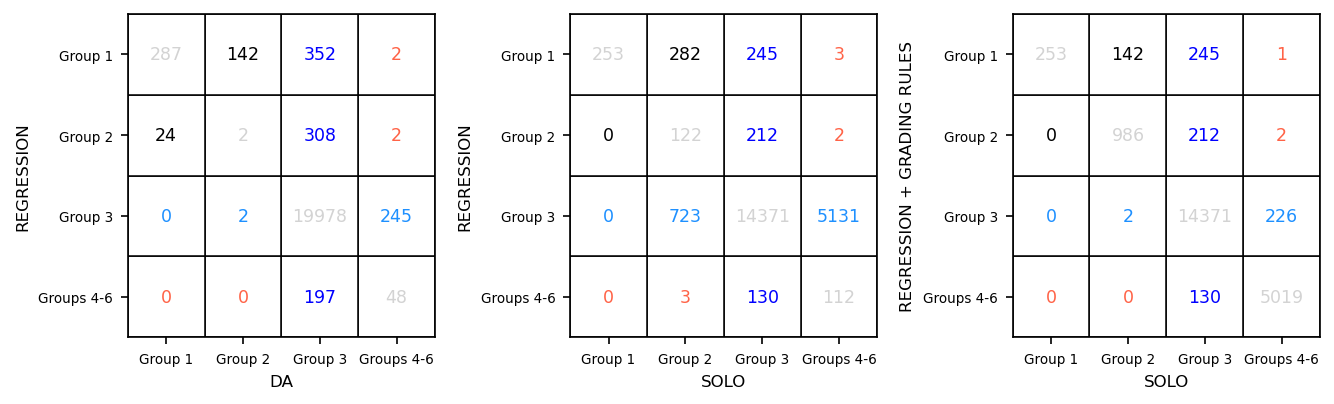

In [92]:
results_final = add_grading_rules_regression(results_final)

regression_vs_DA = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO INITIAL CONFIDENCE GRADING', silent=True)

regression_vs_SOLO = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

regressionRules_vs_SOLO = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION + GRADING RULES', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

custom_coloring_heatmap(regression_vs_DA, regression_vs_SOLO, regressionRules_vs_SOLO, saveName="../results/Figures/comparison_heatmaps.png")

In [93]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (results_final['SOLO INITIAL CONFIDENCE GRADING'].str.contains('Not assoc w R'))]

,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,WHO_BH_LRT_pval,WHO_LRT_neutral_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,Drug,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION + GRADING RULES
1089,mmpS5_c.-74G>T,upstream_gene_variant,1.409350,0.000,0.000000,1.000,1.0,1.462151e-14,8.151491e-13,1.000000,...,0.050949,0.991570,0.994490,Assoc w R - Interim,Assoc w R,NaN,Bedaquiline,5) Not assoc w R,4) Not assoc w R - Interim,Assoc w S - Interim
1915,rrs_n.514A>C,non_coding_transcript_exon_variant,1.125086,0.000,0.000000,0.999,1.0,4.245065e-04,3.099368e-03,0.999575,...,0.091168,0.974569,0.979423,Assoc w R,Assoc w R,NaN,Capreomycin,5) Not assoc w R,5) Not assoc w R,Assoc w R
17139,pncA_p.Ala102Val,missense_variant,1.076908,0.000,0.000000,0.967,1.0,9.394018e-07,3.783558e-06,0.999999,...,0.003037,0.998602,0.999544,Assoc w R - Interim,Assoc w R - Interim,WHO ALL significant both tests,Pyrazinamide,4) Not assoc w R - Interim,4) Not assoc w R - Interim,Assoc w R - Interim
17356,pncA_p.Phe58Val,missense_variant,1.037240,0.011,0.020354,0.926,1.0,2.541549e-02,4.563521e-02,0.974585,...,0.002039,0.998753,0.999631,Assoc w R - Interim,Assoc w R - Interim,WHO ALL significant both tests,Pyrazinamide,4) Not assoc w R - Interim,4) Not assoc w R - Interim,Assoc w R - Interim


In [94]:
results_final.loc[(~results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (results_final['SOLO INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R'))][['mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'WHO_BH_LRT_pval', 'WHO_Present_R', 'WHO_Present_S', 'Initial confidence grading WHO dataset', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'ALL_Present_R', 'ALL_Present_S', 'Initial confidence grading ALL dataset']]

,mutation,WHO_Odds_Ratio,WHO_BH_pval,WHO_BH_LRT_pval,WHO_Present_R,WHO_Present_S,Initial confidence grading WHO dataset,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_LRT_pval,ALL_Present_R,ALL_Present_S,Initial confidence grading ALL dataset
17266,pncA_p.Asp49fs,1.032822,0.062879,0.057282,1.0,1.0,Uncertain,1.046944,0.014776,0.001532,2.0,1.0,Assoc w R - Interim
17430,pncA_p.Thr22fs,1.053157,0.000000,0.001821,2.0,0.0,Assoc w R - Interim,1.022121,0.092698,0.194983,2.0,4.0,Uncertain


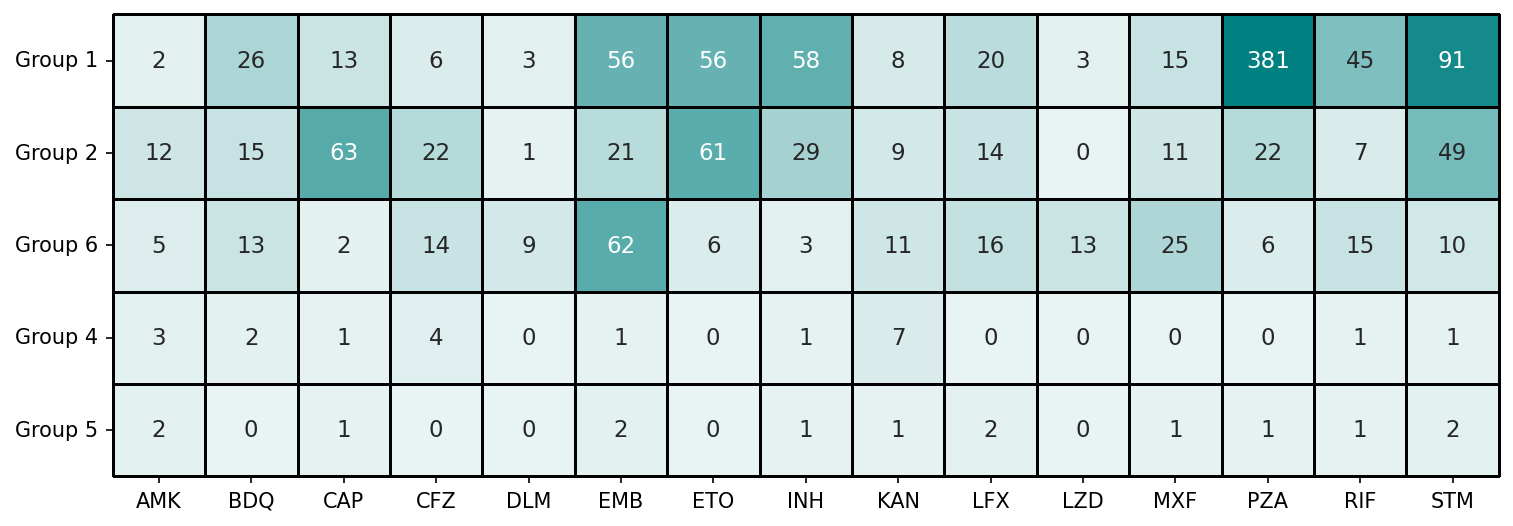

In [95]:
# regression_drug_summary = pd.DataFrame(pd.concat([results_all_drugs, PTM_results]).groupby("Drug")['FINAL CONFIDENCE GRADING'].value_counts()).reset_index().rename(columns={"FINAL CONFIDENCE GRADING": "confidence"})

regression_drug_summary = pd.DataFrame(results_final.groupby("Drug")['REGRESSION FINAL CONFIDENCE GRADING'].value_counts()).reset_index().rename(columns={"REGRESSION FINAL CONFIDENCE GRADING": "confidence"})

regression_drug_summary['confidence'] = regression_drug_summary['confidence'].replace('Assoc w R', 'Group 1').replace('Assoc w R - Interim', 'Group 2').replace('Assoc w S', 'Group 5').replace('Assoc w S - Interim', 'Group 4').replace('Neutral', 'Group 6')

regression_drug_summary = regression_drug_summary.pivot(index='confidence', columns='Drug', values='count').fillna(0).astype(int)
# solo_drug_summary = pd.DataFrame(results_all_drugs.groupby("Drug")['SOLO FINAL CONFIDENCE GRADING'].value_counts()).reset_index().rename(columns={"SOLO FINAL CONFIDENCE GRADING": "confidence"})

# drug_summary = pd.concat([regression_drug_summary, solo_drug_summary])
# regression_drug_summary = regression_drug_summary.loc[['1) Assoc w R', '2) Assoc w R - Interim', '6) Neutral', '4) Assoc w S - Interim', '5) Assoc w S']]
regression_drug_summary = regression_drug_summary.loc[['Group 1', 'Group 2', 'Group 6', 'Group 4', 'Group 5']]

fig, ax = plt.subplots(figsize=(12, 4))

sns.heatmap(regression_drug_summary, 
            fmt="g",
            cmap=sns.light_palette("teal", as_cmap=True),
            vmin=0,
            vmax=100,
            cbar=False,
            square=True,
            annot=True,
            annot_kws={"size": 11},
            linewidths=0.5, 
            linecolor='black',
            ax=ax,
            clip_on=False
           )

ax.set_xticks(ticks=ax.get_xticks(), labels=[drug_abbr_dict[drug] for drug in regression_drug_summary.columns], rotation=0)
ax.set_yticks(ticks=ax.get_yticks(), labels=ax.get_yticklabels(), rotation=0)

ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig("../results/Figures/summary_heatmap_by_drug.png", dpi=300, bbox_inches='tight')

# 5. INH Compensatory and Neutral Controls

In [96]:
compens_lst = ['c.-47_-46insT', 'c.-48G>A', 'c.-51G>A', 'c.-81C>T', 'c.-76T>A', 'c.-57C>T', 'c.-52C>T', 'c.-52C>A', 'c.-88_-87insAT', 'c.-77T>G', 'c.-72C>T', 'c.-54C>T', 'c.-74G>A', ]
compens_lst = ["ahpC_" + val for val in compens_lst]
print(len(np.unique(compens_lst)))

13


In [97]:
results_final.query("Drug=='Isoniazid' & mutation in @compens_lst")[['mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']].sort_values(['REGRESSION FINAL CONFIDENCE GRADING', "ALL_Odds_Ratio"], ascending=[True, False])

,mutation,WHO_Odds_Ratio,WHO_BH_pval,ALL_Odds_Ratio,ALL_BH_pval,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING
10319,ahpC_c.-57C>T,1.164950,0.000000,1.165688,0.000000,Assoc w R,3) Uncertain significance,3) Uncertain significance
10320,ahpC_c.-48G>A,1.168466,0.000000,1.161708,0.000000,Assoc w R,3) Uncertain significance,3) Uncertain significance
10322,ahpC_c.-52C>T,1.138770,0.000000,1.136834,0.000000,Assoc w R,3) Uncertain significance,3) Uncertain significance
10323,ahpC_c.-54C>T,1.125298,0.000000,1.133144,0.000000,Assoc w R,3) Uncertain significance,3) Uncertain significance
10331,ahpC_c.-76T>A,1.138026,0.000000,1.097204,0.000000,Assoc w R,3) Uncertain significance,3) Uncertain significance
10343,ahpC_c.-72C>T,1.045260,0.000000,1.080957,0.000000,Assoc w R,3) Uncertain significance,3) Uncertain significance
10341,ahpC_c.-47_-46insT,1.061279,0.000000,1.083090,0.000000,Uncertain,3) Uncertain significance,3) Uncertain significance
10351,ahpC_c.-52C>A,1.077763,0.000000,1.073249,0.000000,Uncertain,3) Uncertain significance,3) Uncertain significance
10367,ahpC_c.-51G>A,1.059372,0.000000,1.062916,0.000000,Uncertain,3) Uncertain significance,3) Uncertain significance
10473,ahpC_c.-81C>T,1.080169,0.000000,1.042175,0.014000,Uncertain,3) Uncertain significance,3) Uncertain significance


# 6. Direct Association-Based Prediction Comparison between SOLO and Regression

<ul>
    <li>SOLO vs. Regression-identified mutations</li>
    <li>Catalog method vs. Regression model</li>
    <li>+/- HETs</li>
</ul>


In [157]:
def single_metric_solo_regression_comparison(drugs_lst, metric="Sens", saveName=None):

    fig, axs = plt.subplots(3, 5, figsize=(11, 11), sharex=True, sharey=True)
    axs = axs.flatten()
    plt.subplots_adjust(wspace=0.05)

    plot_df = []
    phenos_name = "ALL"
    
    for drug in drugs_lst:
    
        if drug != "Pretomanid":
            stats_solo_initial = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75_SOLO_initial_withLoF.csv"))
            stats_solo_initial['Drug'] = drug
            stats_solo_initial['Model'] = 'DA'
            
            stats_solo_final = solo_binary_stats.query("Drug==@drug").reset_index()
            stats_solo_final['Model'] = 'SOLO'

            stats_regression = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75_withLoF.csv"))
            stats_regression['Drug'] = drug
            
            # plot_df.append(stats)
            plot_df.append(stats_solo_initial)
            plot_df.append(stats_solo_final)
            plot_df.append(stats_regression)

    # drop columns (metrics) that have NaNs because they're not in the SOLO dataframe
    plot_df = pd.concat(plot_df, axis=0).dropna(axis=1).set_index('Model')
    
    # Categories and metric names
    # categories = ['SOLO Initial', 'SOLO Final', 'Regression Initial', 'Regression Final']
    categories = ['DA', 'SOLO', 'Regression']

    # SOLO green, Regression orange
    colors = {'DA': sns.color_palette("Set3").as_hex()[0],#sns.color_palette("Set2")[0], 
              'Regression': sns.color_palette("Set3").as_hex()[5], #sns.color_palette("Set2")[1], 
              'SOLO': sns.color_palette("Set3").as_hex()[2], #sns.color_palette("Set2")[2]
             }
    
    # colors = dict(zip(categories, np.concatenate([sns.color_palette("Paired")[:2], sns.color_palette("Paired")[6:8]])))
    
    # Bar width and positions
    bar_width = 0.05
    # bar_positions = np.arange(len(categories))
    
    errwidth = 0.04
    errlinewidth = 0.5
    
    for i, drug in enumerate(np.sort(plot_df['Drug'].unique())):

        single_drug_plot_df = plot_df.query("Drug==@drug")
        del single_drug_plot_df['Drug'] # remove so that the only remaining columns are numeric

        var1, var2 = metrics_components_dict[metric]
        # metric_pval = compute_ci_ztest(single_drug_plot_df, metric, var1, var2, single_drug_plot_df.index.values[0], single_drug_plot_df.index.values[1])
        
        ax = axs[i]
        
        # Plot bars for each category
        for j, category in enumerate(categories):
    
            test = single_drug_plot_df.loc[category][metric] * 100
            lower = single_drug_plot_df.loc[category][f"{metric}_lb"] * 100
            upper = single_drug_plot_df.loc[category][f"{metric}_ub"] * 100
            
            # Plot the test value as a bar
            patch = ax.bar(j, test, color=colors[category], label=category, linewidth=0.5, edgecolor='black')#, alpha=0.75)
            ax.bar_label(patch, label_type='center', fmt='%.1f')
            
            # Plot the confidence interval as a vertical line
            ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
    
            # plot horizontal lines to make the error bars look nicer
            ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
            ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
        
        ax.set_title(drug, fontsize=10)
        
        # remove x-axis ticks and labels
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Show the plot
    # plt.legend(bbox_to_anchor=(0.08, -0.17), loc="lower right", ncol=len(categories))
    plt.legend(bbox_to_anchor=(-0.55, -0.17), loc="lower right", ncol=len(categories))
    sns.despine()
    plt.tight_layout()
    plt.ylim(0, 100)
    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, dpi=300, bbox_inches="tight")

    return plot_df

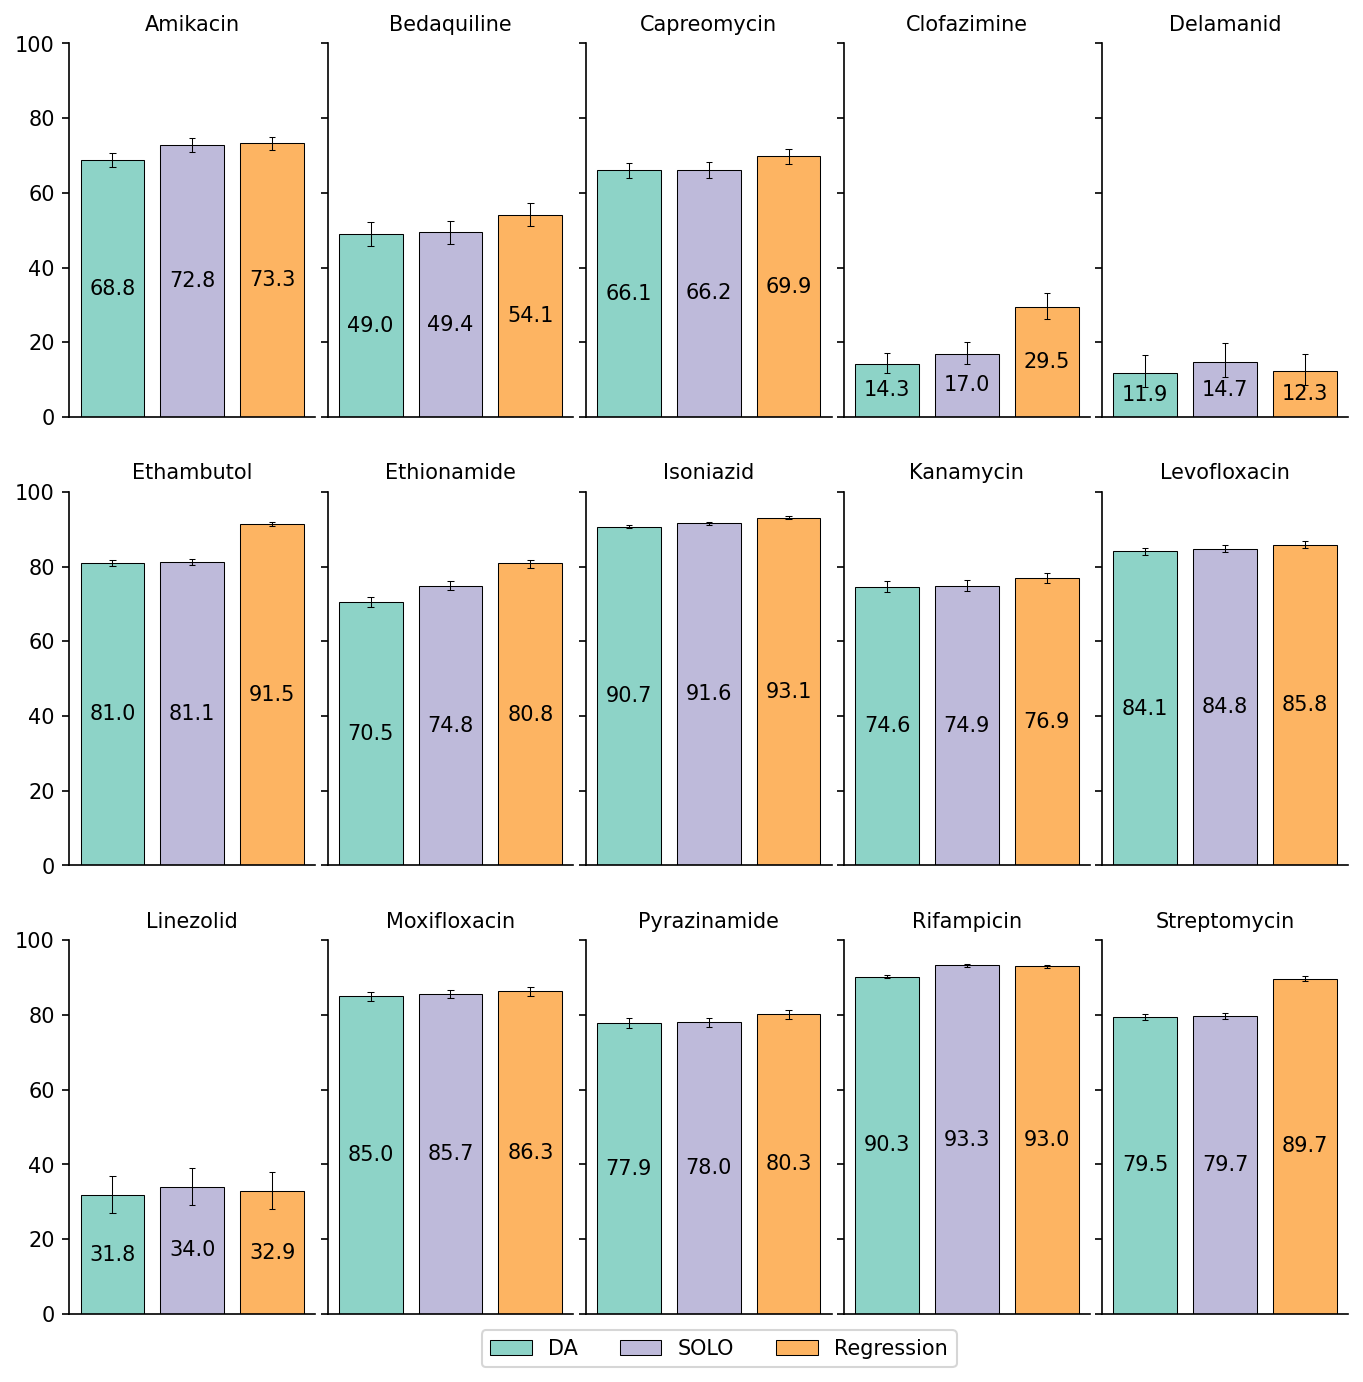

In [158]:
binary_metrics_df = single_metric_solo_regression_comparison(drugs_lst, metric="Sens", saveName="../results/Figures/solo_regression_sensitivity_withLoF.png")

In [166]:
binary_metrics_df.sort_values("Drug").to_csv("../supplement/Table_S7.csv")

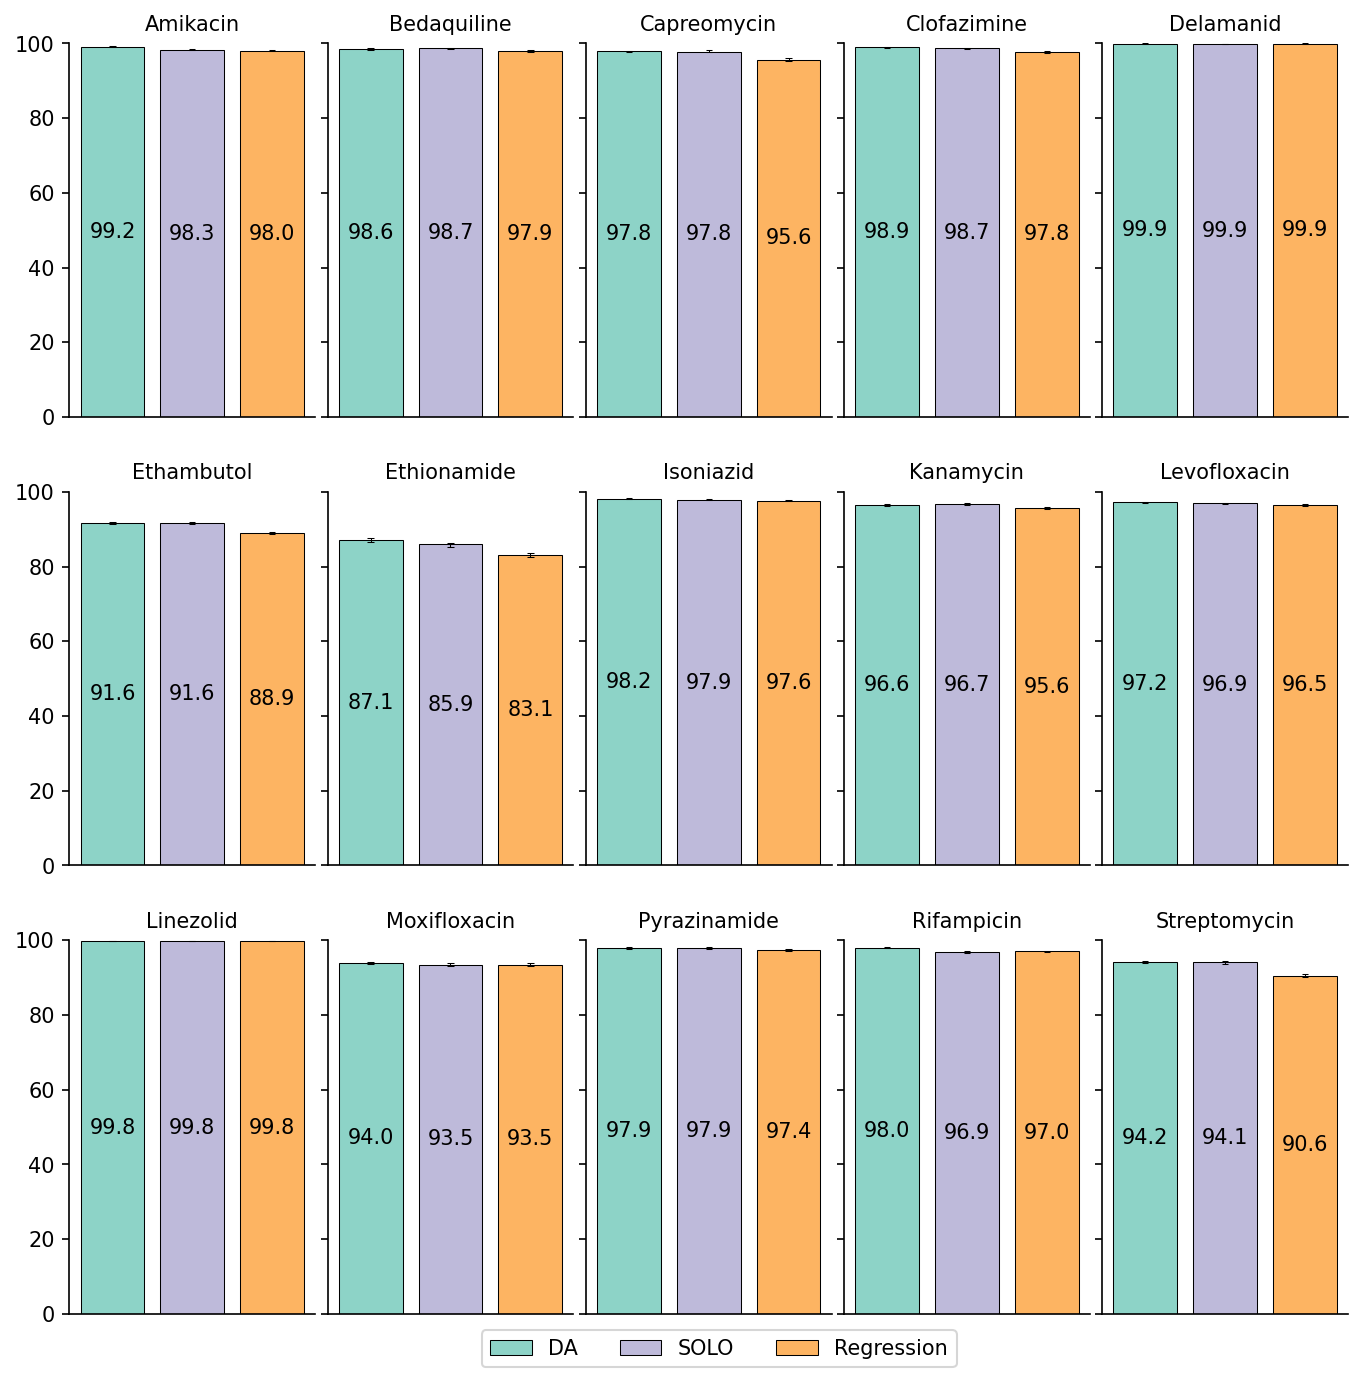

In [5]:
_ = single_metric_solo_regression_comparison(drugs_lst, metric="Spec", saveName="../results/Figures/solo_regression_specificity_withLoF.png")

In [33]:
# F1 scores
print(f"DA F1: {binary_metrics_df.loc['DA']['F1'].mean()*100}")
print(f"SOLO F1: {binary_metrics_df.loc['SOLO']['F1'].mean()*100}")
print(f"Regression F1: {binary_metrics_df.loc['Regression']['F1'].mean()*100}")

DA F1: 69.18524959127681
SOLO F1: 69.94689238258516
Regression F1: 70.5193792759546


In [10]:
diff_df_SOLO_initial = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_SOLO_initial.index.values:
    for metric in diff_df_SOLO_initial.columns:
        diff_df_SOLO_initial.loc[drug, metric] = binary_metrics_df.query("Drug==@drug").loc["Regression", metric] - binary_metrics_df.query("Drug==@drug").loc["DA", metric]

diff_df_SOLO_initial['combined_diff'] = (np.abs(diff_df_SOLO_initial['Sens']) + np.abs(diff_df_SOLO_initial['Spec'])) / 2

In [11]:
diff_df_SOLO_final = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_SOLO_final.index.values:
    for metric in diff_df_SOLO_final.columns:
        diff_df_SOLO_final.loc[drug, metric] = binary_metrics_df.query("Drug==@drug").loc["Regression", metric] - binary_metrics_df.query("Drug==@drug").loc["SOLO", metric]

In [16]:
# regression higher, same, less sensitivity
len(diff_df_SOLO_initial.query("Sens > 0")), len(diff_df_SOLO_initial.query("Sens == 0")), len(diff_df_SOLO_initial.query("Sens < 0"))

(15, 0, 0)

In [20]:
# regression higher, same, less specificity
len(diff_df_SOLO_initial.query("Spec > 0")), len(diff_df_SOLO_initial.query("Spec == 0")), len(diff_df_SOLO_initial.query("Spec < 0"))

(0, 1, 14)

In [23]:
diff_df_SOLO_initial.query("Spec == 0")

,Sens,Spec,PPV,NPV,F1,combined_diff
Delamanid,0.003968,0.0,0.004979,0.000083,0.006181,0.001984


In [35]:
print(f"Min. Sens difference betwen regression and DA: {diff_df_SOLO_initial.Sens.min()*100}")
print(f"Max. Sens difference betwen regression and DA: {diff_df_SOLO_initial.Sens.max()*100}")
print(f"Mean Sens difference betwen regression and DA: {diff_df_SOLO_initial.Sens.mean()*100}")

Min. Sens difference betwen regression and DA: 0.3968253968253996
Max. Sens difference betwen regression and DA: 15.214180206794678
Mean Sens difference betwen regression and DA: 4.93472924837715


In [36]:
print(f"Min. Spec difference betwen regression and DA: {diff_df_SOLO_initial.Spec.min()*100}")
print(f"Max. Spec difference betwen regression and DA: {np.sort(diff_df_SOLO_initial.Spec)[-2]*100}") # exclude Delamanid
print(f"Mean Spec difference betwen regression and DA: {diff_df_SOLO_initial.Spec.mean()*100}")

Min. Spec difference betwen regression and DA: -4.058617394074549
Max. Spec difference betwen regression and DA: -0.011340440009088848
Mean Spec difference betwen regression and DA: -1.3114018496540636


In [41]:
diff_df_SOLO_initial.sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1,combined_diff
Clofazimine,0.152142,-0.011457,-0.000403,0.006427,0.126012,0.081799
Ethambutol,0.104446,-0.026766,-0.032454,0.027254,0.022449,0.065606
Ethionamide,0.102843,-0.040586,-0.032083,0.029889,0.023453,0.071715
Streptomycin,0.102402,-0.03605,-0.037356,0.056093,0.035442,0.069226
Bedaquiline,0.051109,-0.007024,-0.063335,0.003557,0.011137,0.029066
Amikacin,0.045565,-0.011291,-0.095312,0.004482,-0.012227,0.028428
Capreomycin,0.038257,-0.021916,-0.122032,0.003882,-0.035236,0.030086
Rifampicin,0.027223,-0.009783,-0.016397,0.013487,0.006264,0.018503
Isoniazid,0.024008,-0.005765,-0.00709,0.016073,0.009319,0.014887
Pyrazinamide,0.023922,-0.005033,-0.01675,0.005503,0.006175,0.014478


In [44]:
diff_df_SOLO_initial.sort_values("Spec", ascending=True)

,Sens,Spec,PPV,NPV,F1,combined_diff
Ethionamide,0.102843,-0.040586,-0.032083,0.029889,0.023453,0.071715
Streptomycin,0.102402,-0.03605,-0.037356,0.056093,0.035442,0.069226
Ethambutol,0.104446,-0.026766,-0.032454,0.027254,0.022449,0.065606
Capreomycin,0.038257,-0.021916,-0.122032,0.003882,-0.035236,0.030086
Clofazimine,0.152142,-0.011457,-0.000403,0.006427,0.126012,0.081799
Amikacin,0.045565,-0.011291,-0.095312,0.004482,-0.012227,0.028428
Rifampicin,0.027223,-0.009783,-0.016397,0.013487,0.006264,0.018503
Kanamycin,0.022695,-0.009613,-0.038694,0.003295,-0.007587,0.016154
Bedaquiline,0.051109,-0.007024,-0.063335,0.003557,0.011137,0.029066
Levofloxacin,0.017535,-0.006727,-0.020421,0.004244,-0.00079,0.012131


In [160]:
def single_metric_HET_comparison(drugs_lst, metric="Sens", solo=False, plot=True, title=None, saveName=None):

    if solo:
        suffix = "_SOLO_initial"
        model_name = "SOLO Initial"
    else:
        suffix = ""
        model_name = "Regression"

    plot_df = []
    phenos_name = "ALL"
    
    for drug in drugs_lst:
    
        if drug != "Pretomanid":
            stats = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75{suffix}_withLoF.csv"))
            stats_het = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF25{suffix}_withLoF.csv"))

            stats['Model'] = ['AF = 75%']
            stats['Drug'] = drug
            
            stats_het['Model'] = ['AF = 25%']
            stats_het['Drug'] = drug

            plot_df.append(stats)
            plot_df.append(stats_het)
        
    # drop columns (metrics) that have NaNs because they're not in the SOLO dataframe
    plot_df = pd.concat(plot_df, axis=0).dropna(axis=1).set_index('Model')

    if plot:

        fig, axs = plt.subplots(3, 5, figsize=(8, 11), sharex=True, sharey=True)
        axs = axs.flatten()
        plt.subplots_adjust(wspace=0.05)
        
        # Categories and metric names
        categories = plot_df.index.unique()
    
        # keep orange color (index 1) for regression, then select the next color for +HETs
        colors = {'AF = 75%': sns.color_palette("Set3").as_hex()[5], 'AF = 25%': sns.color_palette("Set3").as_hex()[4]}
        
        # Bar width and positions
        bar_width = 0.05
        # bar_positions = np.arange(len(categories))
        
        errwidth = 0.04
        errlinewidth = 0.5
        
        for i, drug in enumerate(np.sort(plot_df['Drug'].unique())):
    
            single_drug_plot_df = plot_df.query("Drug==@drug")
            del single_drug_plot_df['Drug'] # remove so that the only remaining columns are numeric
    
            var1, var2 = metrics_components_dict[metric]        
            ax = axs[i]
            
            # Plot bars for each category
            for j, category in enumerate(categories):
        
                test = single_drug_plot_df.loc[category][metric] * 100
                lower = single_drug_plot_df.loc[category][f"{metric}_lb"] * 100
                upper = single_drug_plot_df.loc[category][f"{metric}_ub"] * 100
                
                # Plot the test value as a bar
                patch = ax.bar(j, test, color=colors[category], label=category, linewidth=0.5, edgecolor='black')
                ax.bar_label(patch, label_type='center', fmt='%.1f')
                
                # Plot the confidence interval as a vertical line
                ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
        
                # plot horizontal lines to make the error bars look nicer
                ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
                ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
    
            ax.set_title(drug, fontsize=10)
            
            # remove x-axis ticks and labels
            ax.set_xticks([])
            ax.set_xticklabels([])
        
        # Show the plot
        plt.legend(bbox_to_anchor=(-0.5, -0.17), loc="lower right", ncol=len(categories))
        sns.despine()
        plt.tight_layout()
        plt.ylim(0, 100)
    
        if title is not None:
            plt.suptitle(title)
        
        sns.despine()
    
        if saveName is None:
            plt.show()
        else:
            plt.savefig(saveName, dpi=300, bbox_inches="tight")

    return plot_df

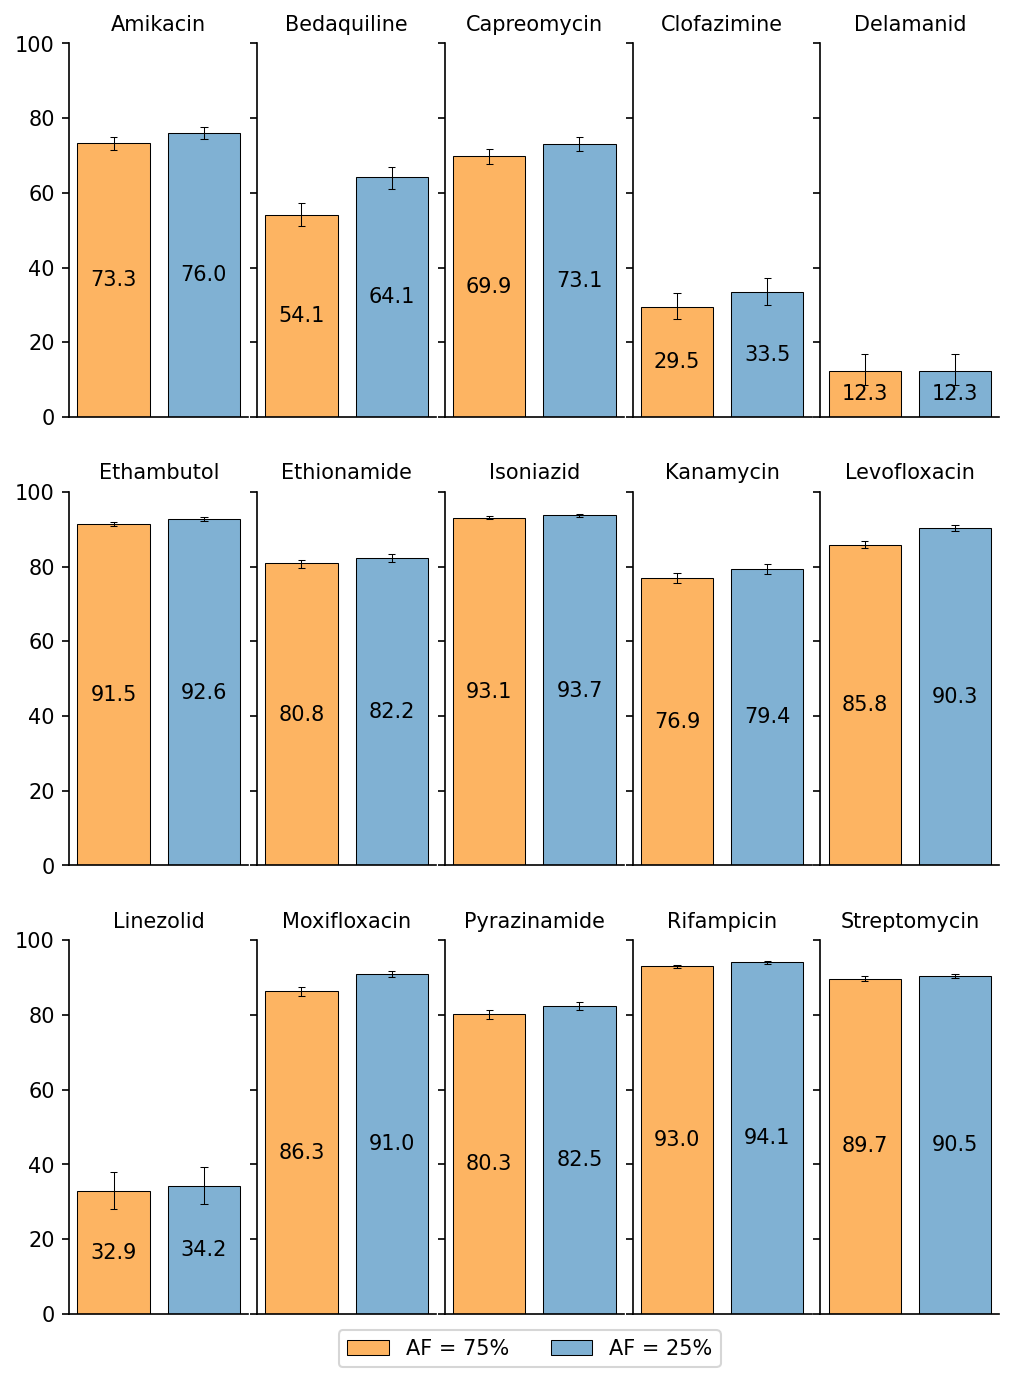

In [161]:
HET_results = single_metric_HET_comparison(drugs_lst, metric="Sens", saveName="../results/Figures/regression_HETs_sensitivity_withLoF.png")

In [165]:
HET_results.sort_values("Drug").to_csv("../supplement/Table_S8.csv")

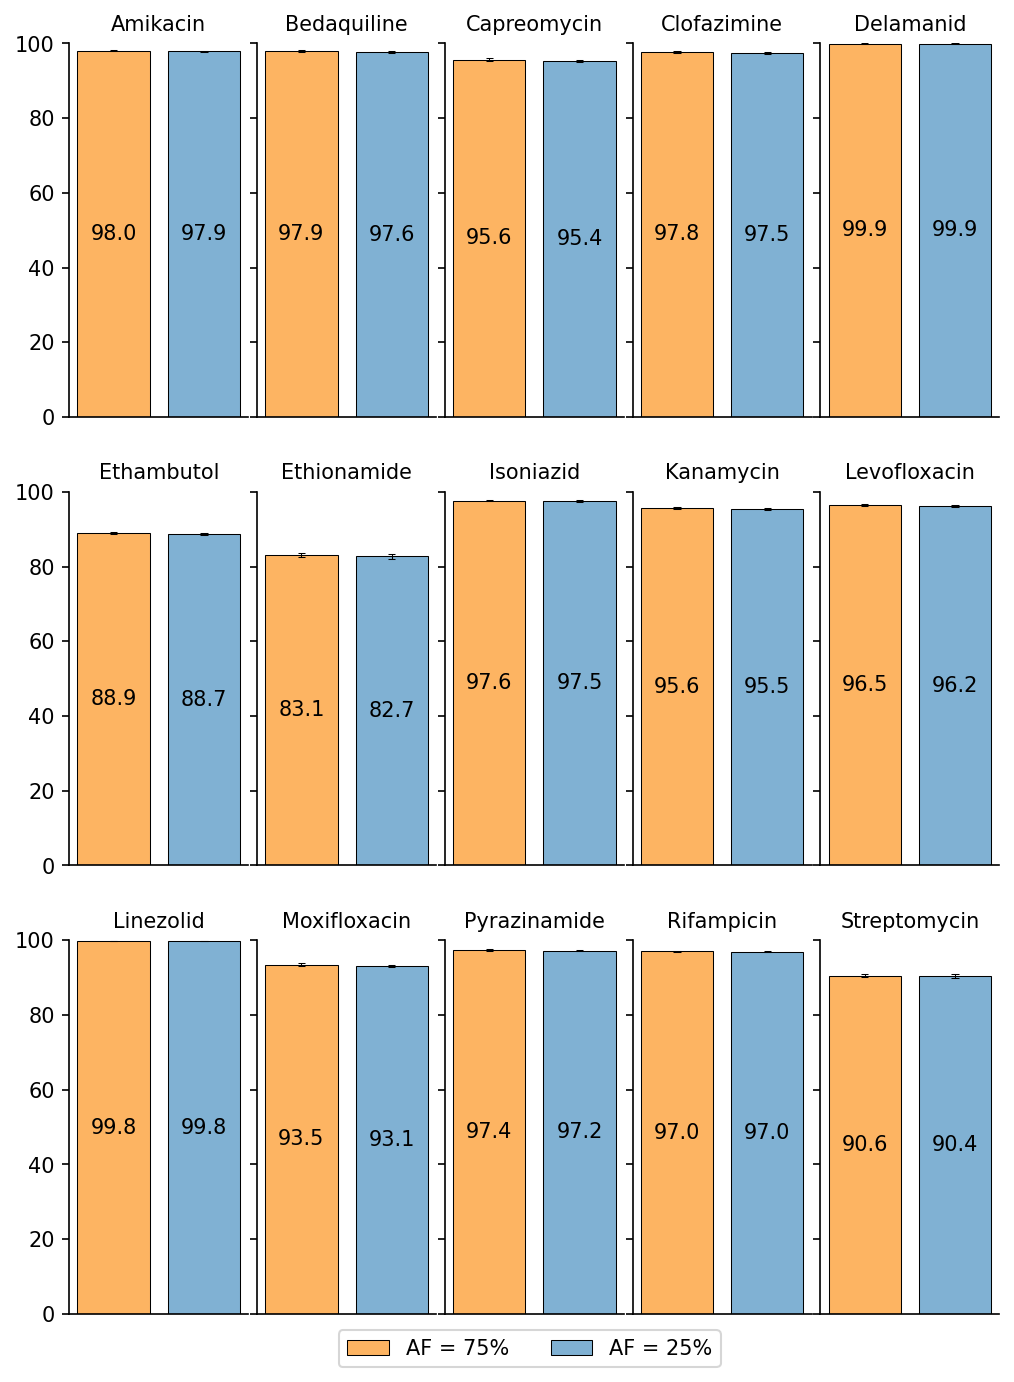

In [39]:
_ = single_metric_HET_comparison(drugs_lst, metric="Spec", saveName="../results/Figures/regression_HETs_specificity_withLoF.png")

In [49]:
diff_df_HET = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_HET.index.values:

    for metric in diff_df_HET.columns:
        diff_df_HET.loc[drug, metric] = HET_results.query("Drug==@drug").loc["AF = 25%", metric] - HET_results.query("Drug==@drug").loc["AF = 75%", metric]

In [49]:
diff_df_HET_SOLO_initial = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_HET_SOLO_initial.index.values:

    for metric in diff_df_HET.columns:
        diff_df_HET_SOLO_initial.loc[drug, metric] = HET_results_SOLO_initial.query("Drug==@drug").loc["AF = 25%", metric] - HET_results_SOLO_initial.query("Drug==@drug").loc["AF = 75%", metric]

In [2]:
def single_metric_catalog_regression(drugs_lst, metric="Sens", plot=True, title=None, suffix="", saveName=None):

    plot_df = []
    phenos_name = "ALL"
    
    for drug in drugs_lst:
    
        if drug != "Pretomanid":
            stats = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75{suffix}.csv"))
            stats_reg = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/regression_stats{suffix}.csv"))

            stats['Model'] = ['Catalog']
            stats['Drug'] = drug
            
            stats_reg['Model'] = ['Regression']
            stats_reg['Drug'] = drug

            plot_df.append(stats)
            plot_df.append(stats_reg)
        
    # drop columns (metrics) that have NaNs because they're not in the SOLO dataframe
    plot_df = pd.concat(plot_df, axis=0).dropna(axis=1).set_index('Model')

    if plot:

        fig, axs = plt.subplots(3, 5, figsize=(8, 11), sharex=True, sharey=True)
        axs = axs.flatten()
        plt.subplots_adjust(wspace=0.05)
        
        # Categories and metric names
        categories = plot_df.index.unique()
    
        # keep orange color (index 1) for regression, then select the next color for +HETs
        colors = {'Catalog': sns.color_palette("Set3").as_hex()[5], 'Regression': sns.color_palette("Set3").as_hex()[2]}
        
        # Bar width and positions
        bar_width = 0.05
        # bar_positions = np.arange(len(categories))
        
        errwidth = 0.04
        errlinewidth = 0.5
        
        for i, drug in enumerate(np.sort(plot_df['Drug'].unique())):
    
            single_drug_plot_df = plot_df.query("Drug==@drug")
            del single_drug_plot_df['Drug'] # remove so that the only remaining columns are numeric
    
            var1, var2 = metrics_components_dict[metric]        
            ax = axs[i]
            
            # Plot bars for each category
            for j, category in enumerate(categories):
        
                test = single_drug_plot_df.loc[category][metric] * 100
                lower = single_drug_plot_df.loc[category][f"{metric}_lb"] * 100
                upper = single_drug_plot_df.loc[category][f"{metric}_ub"] * 100
                
                # Plot the test value as a bar
                patch = ax.bar(j, test, color=colors[category], label=category, linewidth=0.5, edgecolor='black')
                ax.bar_label(patch, label_type='center', fmt='%.1f')
                
                # Plot the confidence interval as a vertical line
                ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
        
                # plot horizontal lines to make the error bars look nicer
                ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
                ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
    
            ax.set_title(drug, fontsize=10)
            
            # remove x-axis ticks and labels
            ax.set_xticks([])
            ax.set_xticklabels([])
        
        # Show the plot
        plt.legend(bbox_to_anchor=(-0.5, -0.17), loc="lower right", ncol=len(categories))
        sns.despine()
        plt.tight_layout()
        plt.ylim(0, 100)
    
        if title is not None:
            plt.suptitle(title)
        
        sns.despine()
    
        if saveName is None:
            plt.show()
        else:
            plt.savefig(saveName, dpi=300, bbox_inches="tight")

    return plot_df

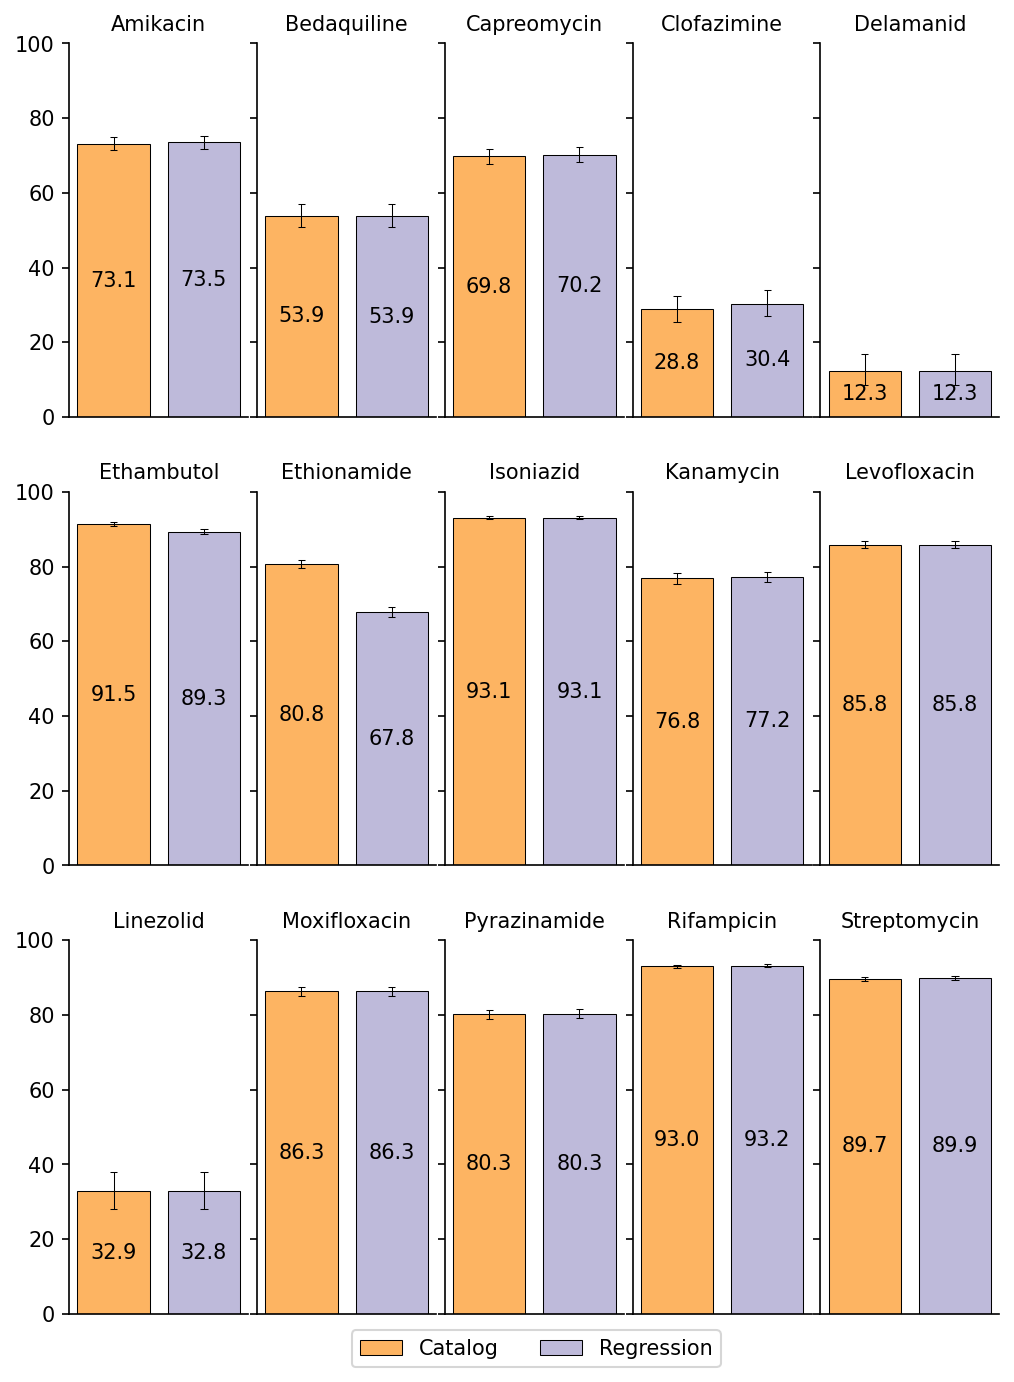

In [3]:
catalog_vs_reg_stats = single_metric_catalog_regression(drugs_lst, metric="Sens", suffix="_withLoF", plot=True)

In [62]:
# catalog_vs_reg_stats = single_metric_catalog_regression(drugs_lst, metric="Spec", plot=True)
# catalog_vs_reg_stats = single_metric_catalog_regression(drugs_lst, metric="Sens", suffix="", plot=True)

# Volcano Plots of MIC Results for Mutations 1) Assoc w R by Regression and Uncertain by SOLO

In [107]:
# variants graded in Groups 1, 2, 4, and 5 by regression and 3 by DA
# search_df = results_final.loc[(~results_final['REGRESSION FINAL CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral'])) & (results_final['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance') & (results_final['ALL_Num_Isolates'] >= 5)].reset_index(drop=True)

search_df = results_final.loc[(~results_final['REGRESSION FINAL CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral'])) & (results_final['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance')].reset_index(drop=True)

# search_df = results_final.loc[(~results_final['REGRESSION FINAL CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral'])) & (~results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Interim')) & (results_final['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance')]

print(search_df.shape)

MIC_results = []

for drug in drugs_lst:

    for model_path in ["dropAF_noSyn_unpooled", "dropAF_noSyn_poolLoF", "dropAF_withSyn_unpooled"]:

        model_analysis_fName = f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/{drug}/MIC/tiers=1/{model_path}/model_analysis.csv"
        model_matrix_fName = f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/{drug}/MIC/tiers=1/{model_path}/model_matrix.pkl"
        
        if os.path.isfile(model_analysis_fName):
            df = pd.read_csv(model_analysis_fName)
            df['Drug'] = drug

            model_matrix = pd.read_pickle(model_matrix_fName)
            
            # # get the number of isolates in which each variant occurs
            # for i, row in df.iterrows():
            #     if not row['mutation'].startswith('PC'):
            #         df.loc[i, 'MIC_Num_Isolates'] = len(model_matrix.loc[model_matrix[row['mutation']]==1])
                    
            MIC_results.append(df)
        else:
            print(model_analysis_fName)

MIC_results = pd.concat(MIC_results).drop_duplicates(["Drug", "mutation"], keep="first")[['Drug', 'mutation', 'coef', 'BH_pval']].rename(columns={'coef': 'MIC_coef', 'BH_pval': 'MIC_BH_pval'})

search_df = search_df.merge(MIC_results, on=['Drug', 'mutation'], how='left')

(684, 61)
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Linezolid/MIC/tiers=1/dropAF_noSyn_poolLoF/model_analysis.csv
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Moxifloxacin/MIC/tiers=1/dropAF_noSyn_poolLoF/model_analysis.csv
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Levofloxacin/MIC/tiers=1/dropAF_noSyn_poolLoF/model_analysis.csv
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Ethambutol/MIC/tiers=1/dropAF_noSyn_poolLoF/model_analysis.csv
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Rifampicin/MIC/tiers=1/dropAF_noSyn_poolLoF/model_analysis.csv


In [99]:
MIC_test_variants = search_df.loc[(~pd.isnull(search_df['MIC_BH_pval']))]

# MIC_test_variants = search_df.query("ALL_Present_SR>= 5")
# print(len(MIC_test_variants))

# MIC_test_variants = MIC_test_variants.loc[~pd.isnull(MIC_test_variants['MIC_BH_pval'])]

print(len(MIC_test_variants))

len(MIC_test_variants.query("MIC_BH_pval <= 0.05"))

366


131

In [103]:
131/366

0.35792349726775957

In [100]:
MIC_test_variants['REGRESSION FINAL CONFIDENCE GRADING'].value_counts()

REGRESSION FINAL CONFIDENCE GRADING
Assoc w R              196
Assoc w R - Interim    152
Assoc w S - Interim     13
Assoc w S                5
Name: count, dtype: int64

In [101]:
denom = len(MIC_test_variants.loc[MIC_test_variants['REGRESSION FINAL CONFIDENCE GRADING'].isin(['Assoc w R', 'Assoc w R - Interim'])])
numer = len(MIC_test_variants.loc[MIC_test_variants['REGRESSION FINAL CONFIDENCE GRADING'].isin(['Assoc w R', 'Assoc w R - Interim'])].query("MIC_coef > 0 & MIC_BH_pval <= 0.05"))
denom, numer, numer/denom

(348, 122, 0.3505747126436782)

In [102]:
denom = len(MIC_test_variants.loc[MIC_test_variants['REGRESSION FINAL CONFIDENCE GRADING'].isin(['Assoc w S', 'Assoc w S - Interim'])])
numer = len(MIC_test_variants.loc[MIC_test_variants['REGRESSION FINAL CONFIDENCE GRADING'].isin(['Assoc w S', 'Assoc w S - Interim'])].query("MIC_coef < 0 & MIC_BH_pval <= 0.05"))
denom, numer, numer/denom

(18, 9, 0.5)

In [104]:
# negative log-p-value
MIC_test_variants['log_MIC_BH_pval'] = -np.log(MIC_test_variants['MIC_BH_pval'])

# # for variants with a p-value of 0, replace with the next smallest p-value
# plot_df.loc[plot_df['MIC_BH_pval'] == 0, 'log_MIC_BH_pval'] = -np.log(np.sort(plot_df['MIC_BH_pval'].unique())[1])

# plot_df.loc[(plot_df['MIC_coef'] > 0) & (plot_df['MIC_BH_pval'] <= 0.05) & (~plot_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Interim')), 'color'] = sns.color_palette("Paired").as_hex()[1] #'cornflowerblue'

# plot_df.loc[(plot_df['MIC_coef'] > 0) & (plot_df['MIC_BH_pval'] <= 0.05) & (plot_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Interim')), 'color'] = sns.color_palette("Paired").as_hex()[0]

# plot_df.loc[(plot_df['MIC_coef'] < 0) & (plot_df['MIC_BH_pval'] <= 0.05)  & (~plot_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Interim')), 'color'] = sns.color_palette("Paired").as_hex()[5] #'darkred'

# plot_df.loc[(plot_df['MIC_coef'] < 0) & (plot_df['MIC_BH_pval'] <= 0.05) & (plot_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Interim')), 'color'] = sns.color_palette("Paired").as_hex()[4]

# for variants with a p-value of 0, replace with the next smallest p-value
MIC_test_variants.loc[MIC_test_variants['MIC_BH_pval'] == 0, 'log_MIC_BH_pval'] = -np.log(np.sort(MIC_test_variants['MIC_BH_pval'].unique())[1])

MIC_test_variants.loc[(MIC_test_variants['MIC_coef'] > 0) & (MIC_test_variants['MIC_BH_pval'] <= 0.05), 'color'] = 'cornflowerblue'
MIC_test_variants.loc[(MIC_test_variants['MIC_coef'] < 0) & (MIC_test_variants['MIC_BH_pval'] <= 0.05), 'color'] = 'darkred'

MIC_test_variants.loc[MIC_test_variants['MIC_BH_pval'] > 0.05, 'color'] = 'lightgray'

#color_dict = dict(zip(plot_df.query("color != 'lightgray'")['REGRESSION FINAL CONFIDENCE GRADING'], plot_df.query("color != 'lightgray'")['color']))

print(MIC_test_variants.shape)

(366, 66)


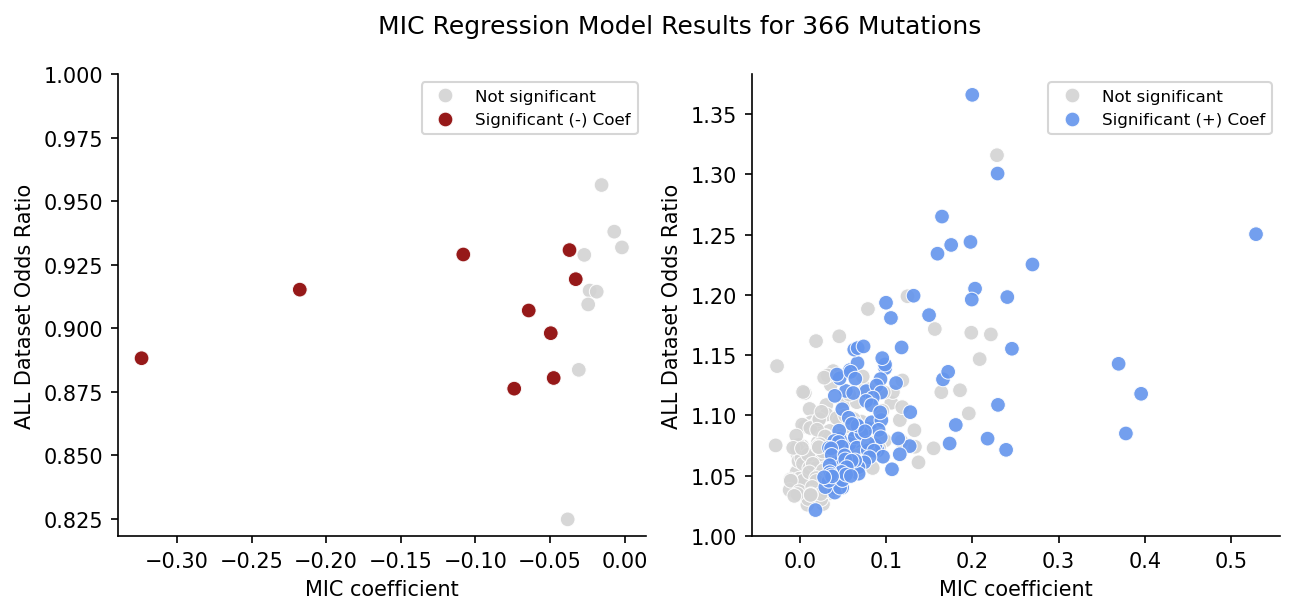

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(data=MIC_test_variants.query("ALL_Odds_Ratio < 1").sort_values('color', ascending=False), # put lightgray at the beginning so it gets plotted below
                x='MIC_coef',
                y='ALL_Odds_Ratio',
                #y='log_MIC_BH_pval',
                hue='color',
                palette={color:color for color in MIC_test_variants.color.unique()},
                #palette={'Assoc w R': sns.color_palette("Paired")[1], 'Assoc w R - Interim': sns.color_palette("Paired")[0], 'Assoc w S': sns.color_palette("Paired")[5], 'Assoc w S - Interim': sns.color_palette("Paired")[4]},
                legend=True,
                alpha=0.9,
                linewidth=0.5,
                s=50,
                ax=axs[0]
               )

sns.scatterplot(data=MIC_test_variants.query("ALL_Odds_Ratio > 1").sort_values('color', ascending=False), # put lightgray at the beginning so it gets plotted below
                x='MIC_coef',
                y='ALL_Odds_Ratio',
                #y='log_MIC_BH_pval',
                hue='color',
                palette={color:color for color in MIC_test_variants.color.unique()},
                #palette={'Assoc w R': sns.color_palette("Paired")[1], 'Assoc w R - Interim': sns.color_palette("Paired")[0], 'Assoc w S': sns.color_palette("Paired")[5], 'Assoc w S - Interim': sns.color_palette("Paired")[4]},
                legend=True,
                alpha=0.9,
                linewidth=0.5,
                s=50,
                ax=axs[1]
               )

# max_val = np.max([np.abs(plot_df.MIC_coef.min()), np.abs(plot_df.MIC_coef.max())]) * 1.1
# plt.xlim(-max_val, max_val)

# axs[0].set_xlim(right=0)
axs[0].set_ylim(top=1)

# axs[1].set_xlim(left=0-0.01)
axs[1].set_ylim(bottom=1)

for ax in axs:
    ax.set_xlabel("MIC coefficient")
    ax.set_ylabel("ALL Dataset Odds Ratio")

# manually create a legend
handles_0, _ = axs[0].get_legend_handles_labels()
ax0_dict = {'lightgray': 'Not significant', 'darkred': 'Significant (-) Coef'}

handles_1, _ = axs[1].get_legend_handles_labels()
ax1_dict = {'lightgray': 'Not significant', 'cornflowerblue': 'Significant (+) Coef'}

axs[0].legend(handles_0, list(ax0_dict.values()), fontsize=8)
axs[1].legend(handles_1, list(ax1_dict.values()), fontsize=8)

plt.suptitle(f"MIC Regression Model Results for {len(MIC_test_variants)} Mutations")
sns.despine()
plt.savefig("../results/Figures/MIC_volcano_plots.png", dpi=300, bbox_inches='tight')

In [106]:
# discrepant significant binary OR / MIC coef
MIC_test_variants.query("MIC_coef > 0 & MIC_BH_pval <= 0.05 & ALL_Odds_Ratio < 1")[['Drug', 'mutation', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval', 'WHO_R_PPV_LB', 'ALL_R_PPV_LB']]

,Drug,mutation,REGRESSION FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval,WHO_R_PPV_LB,ALL_R_PPV_LB


In [107]:
# discrepant significant binary OR / MIC coef
MIC_test_variants.query("MIC_coef < 0 & MIC_BH_pval <= 0.05 & ALL_Odds_Ratio > 1")[['Drug', 'mutation', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval', 'WHO_R_PPV_LB', 'ALL_R_PPV_LB']]

,Drug,mutation,REGRESSION FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval,WHO_R_PPV_LB,ALL_R_PPV_LB


In [108]:
search_df.query("Drug=='Rifampicin'").loc[(search_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (search_df['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')][['mutation', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'WHO_Present_SR', 'ALL_Present_SR', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval']]

,mutation,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_LRT_pval,WHO_Present_SR,ALL_Present_SR,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval
537,rpoB_p.Ile491Leu,1.110584,0.0,0.000030,10.0,31.0,Assoc w R,3) Uncertain significance,3) Uncertain significance,0.106049,0.060513
541,rpoB_p.Phe424Val,1.091412,0.0,0.000787,14.0,18.0,Assoc w R,3) Uncertain significance,3) Uncertain significance,0.072260,0.418710
542,rpoB_p.Ser493Leu,1.090038,0.0,0.000047,13.0,17.0,Assoc w R,3) Uncertain significance,3) Uncertain significance,0.051408,0.556055
547,rpoB_p.Ile491Met,1.074172,0.0,0.000005,13.0,19.0,Assoc w R,3) Uncertain significance,3) Uncertain significance,0.042541,0.577447
554,rpoB_p.Ile491Thr,1.064873,0.0,0.029397,7.0,9.0,Assoc w R,3) Uncertain significance,3) Uncertain significance,0.001667,0.577447
557,rpoB_p.Ile491Tyr,1.059041,0.0,0.000064,2.0,3.0,Assoc w R - Interim,3) Uncertain significance,3) Uncertain significance,0.054205,0.360436
560,rpoB_p.Leu378Arg,1.038195,0.0,0.157514,11.0,15.0,Assoc w R,3) Uncertain significance,3) Uncertain significance,-0.012001,0.577447


In [113]:
INH_regression_upgrade_noMIC = search_df.query("Drug=='Isoniazid' & ALL_Present_SR >= 5 & MIC_BH_pval > 0.05").loc[(search_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (search_df['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance')]

INH_regression_upgrade_noMIC.shape

(33, 63)

In [110]:
compens_lst = ['c.-47_-46insT', 'c.-48G>A', 'c.-51G>A', 'c.-81C>T', 'c.-76T>A', 'c.-57C>T', 'c.-52C>T', 'c.-52C>A', 'c.-88_-87insAT', 'c.-77T>G', 'c.-72C>T', 'c.-54C>T', 'c.-74G>A', ]
compens_lst = ["ahpC_" + val for val in compens_lst]
print(len(np.unique(compens_lst)))

13


In [114]:
INH_regression_upgrade_noMIC.query("mutation in @compens_lst").shape

(5, 63)

In [148]:
INH_regression_upgrade_noMIC.query("mutation not in @compens_lst")['SOLO FINAL CONFIDENCE GRADING'].value_counts()

SOLO FINAL CONFIDENCE GRADING
3) Uncertain significance     23
2) Assoc w R - Interim         4
4) Not assoc w R - Interim     1
Name: count, dtype: int64

# Results Section E

In [147]:
S_assoc_df = results_final.loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w S')][['Drug', 'mutation', 'WHO_Odds_Ratio', 'ALL_Odds_Ratio', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']].merge(MIC_results, on=['Drug', 'mutation'], how='left').merge(who_variants[['drug', 'variant', 'Present_SOLO_S', 'Present_SOLO_R']].rename(columns={'drug': 'Drug', 'variant': 'mutation'}), on=['Drug', 'mutation'], how='left').sort_values(['Drug', 'ALL_Odds_Ratio'], ascending=True)

# to make it easier to read in the table
solo_mapping_dict = {'3) Uncertain significance': 3, '4) Not assoc w R - Interim': 4, '5) Not assoc w R': 5}
regression_mapping_dict = {'Assoc w S - Interim': 4, 'Assoc w S': 5}

S_assoc_df['SOLO INITIAL CONFIDENCE GRADING'] = S_assoc_df['SOLO INITIAL CONFIDENCE GRADING'].map(solo_mapping_dict)
S_assoc_df['SOLO FINAL CONFIDENCE GRADING'] = S_assoc_df['SOLO FINAL CONFIDENCE GRADING'].map(solo_mapping_dict)
S_assoc_df['REGRESSION FINAL CONFIDENCE GRADING'] = S_assoc_df['REGRESSION FINAL CONFIDENCE GRADING'].map(regression_mapping_dict)

S_assoc_df.to_csv("../results/Table_9.csv", index=False)
len(S_assoc_df), S_assoc_df.Drug.nunique(), len(S_assoc_df.query("MIC_BH_pval <= 0.05 & MIC_coef < 1"))

(35, 12, 12)

In [113]:
S_assoc_df.loc[S_assoc_df['SOLO INITIAL CONFIDENCE GRADING'] != S_assoc_df['SOLO FINAL CONFIDENCE GRADING']]

,Drug,mutation,WHO_Odds_Ratio,ALL_Odds_Ratio,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval,Present_SOLO_S,Present_SOLO_R


In [112]:
S_assoc_df.ALL_Odds_Ratio.min(), S_assoc_df.ALL_Odds_Ratio.max()

(0.5026124194896839, 0.9594385584564074)

# Regression Uncertain, DA Groups 4-5 Analysis

In [144]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Uncertain')) & (results_final['SOLO INITIAL CONFIDENCE GRADING'].str.contains('Not assoc w R'))]['SOLO INITIAL CONFIDENCE GRADING'].value_counts()

SOLO INITIAL CONFIDENCE GRADING
5) Not assoc w R              229
4) Not assoc w R - Interim     16
Name: count, dtype: int64

In [145]:
regressionUncertain_DANotAssoc = results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Uncertain')) & (results_final['SOLO INITIAL CONFIDENCE GRADING'].str.contains('Not assoc w R'))]

print(len(regressionUncertain_DANotAssoc))

regressionUncertain_DANotAssoc_for_merge = regressionUncertain_DANotAssoc[['Drug', 'mutation']]
regressionUncertain_DANotAssoc_for_merge.columns = ['drug', 'variant']

245


In [146]:
regressionUncertain_DANotAssoc[['Drug', 'mutation', 'WHO_Present_SR', 'WHO_R_PPV_UB', 'WHO_S_PPV_UB', 'ALL_Present_SR', 'ALL_R_PPV_UB', 'ALL_S_PPV_UB']]

,Drug,mutation,WHO_Present_SR,WHO_R_PPV_UB,WHO_S_PPV_UB,ALL_Present_SR,ALL_R_PPV_UB,ALL_S_PPV_UB
5,Amikacin,rrs_n.514A>C,340.0,0.345669,0.753805,909.0,0.394134,0.669364
7,Amikacin,eis_c.-10G>A,282.0,0.081894,0.972596,385.0,0.082172,0.965922
52,Amikacin,eis_c.-12C>T,640.0,0.091197,0.949605,947.0,0.084316,0.948505
55,Amikacin,whiB7_p.Gly64fs,44.0,0.080420,1.000000,95.0,0.073987,0.997440
89,Amikacin,eis_p.Val163Ile,122.0,0.103973,0.981740,737.0,0.086948,0.950412
...,...,...,...,...,...,...,...,...
21240,Streptomycin,Rv1258c_p.Gly363Val,39.0,0.134764,0.999351,57.0,0.093917,0.999556
21242,Streptomycin,gid_c.615A>G,9685.0,0.483621,0.536367,12347.0,0.488163,0.529540
21243,Streptomycin,gid_c.330G>T,1759.0,0.168829,0.865212,1955.0,0.181372,0.851970
21244,Streptomycin,gid_p.Leu16Arg,2062.0,0.328877,0.711455,3240.0,0.335811,0.696596


# Neutral Example for Figure S3

In [5]:
thresh = 0.05
solo_neutral = who_variants.query("Neutral_masked==True").variant.values

results_final_April.query("WHO_BH_pval > @thresh & WHO_BH_neutral_pval <= @thresh & WHO_BH_LRT_neutral_pval <= @thresh & WHO_Present_SR >= 5 & mutation in @solo_neutral")[['Drug', 'mutation', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']]

,Drug,mutation,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING
14847,Levofloxacin,gyrB_c.1983C>T,5) Not assoc w R,5) Not assoc w R
16777,Moxifloxacin,gyrB_c.1578G>A,3) Uncertain significance,4) Not assoc w R - Interim
16913,Moxifloxacin,gyrB_c.1983C>T,5) Not assoc w R,5) Not assoc w R
18803,Rifampicin,rpoB_p.Ser388Leu,5) Not assoc w R,5) Not assoc w R


In [10]:
def plot_permutation_df(permute_df, coef_df, model_analysis, variant, saveName=None):

    fig, ax = plt.subplots(figsize=(4, 3))

    y_array = np.exp(permute_df[variant])
    OR = np.round(model_analysis.query("mutation==@variant")['Odds_Ratio'].values[0], 2)

    if OR == 1:
        OR = np.round(model_analysis.query("mutation==@variant")['Odds_Ratio'].values[0], 4)
    
    sns.histplot(x=y_array,
                 ax=ax,
                )
    
    plt.axvline(x=np.exp(coef_df.query("mutation==@variant")['coef'].values[0]), color='tomato', label=f'OR = {OR}')
    plt.title(f"Permuted Model ORs for {variant}", fontsize='9')
    plt.xlabel("Odds Ratio", fontsize='9')
    plt.ylabel('', fontsize='9')

    plt.xticks(fontsize='8')
    plt.yticks(ticks=[], fontsize='8')
    plt.legend(fontsize='7')
    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, dpi=300, bbox_inches='tight')

p-value: 0.02


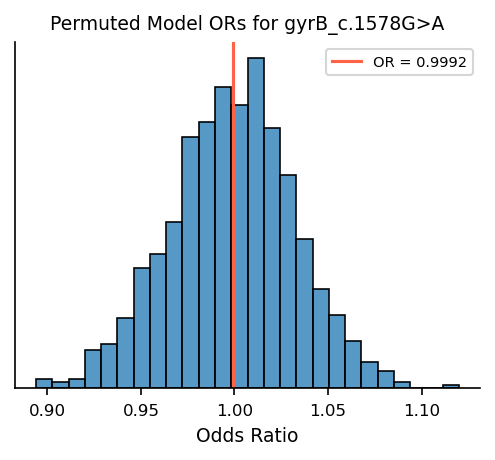

In [11]:
drug = 'Moxifloxacin'
model_prefix = 'dropAF_withSyn_unpooled'
model_prefix = f"BINARY/tiers=1/phenos=WHO/{model_prefix}"

permute_df = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "coef_permutation.csv"))
coef_df = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "regression_coef.csv"))
model_analysis = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "model_analysis.csv"))

neutral_variant = 'gyrB_c.1578G>A'
pval = model_analysis.query("mutation==@neutral_variant")['neutral_pval'].values[0]
print(f"p-value: {pval}")
plot_permutation_df(permute_df, coef_df, model_analysis, neutral_variant, saveName='../supplement/Figures/neutral_permutation.png')

p-value: 0.0
p-value: 0.0


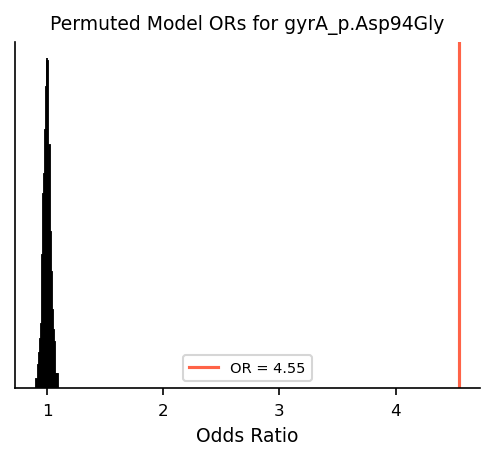

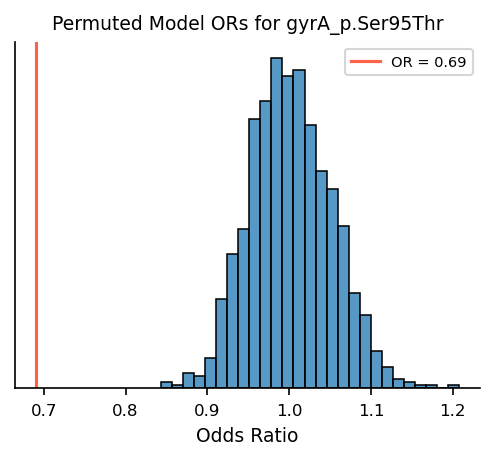

In [12]:
drug = 'Moxifloxacin'
model_prefix = 'dropAF_noSyn_unpooled'
model_prefix = f"BINARY/tiers=1/phenos=WHO/{model_prefix}"

permute_df = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "coef_permutation.csv"))
coef_df = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "regression_coef.csv"))
model_analysis = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "model_analysis.csv"))

R_assoc_variant = 'gyrA_p.Asp94Gly'
S_assoc_variant = 'gyrA_p.Ser95Thr'

pval = model_analysis.query("mutation==@R_assoc_variant")['pval'].values[0]
print(f"p-value: {pval}")
plot_permutation_df(permute_df, coef_df, model_analysis, R_assoc_variant, saveName='../supplement/Figures/R_assoc_permutation.png')

pval = model_analysis.query("mutation==@S_assoc_variant")['pval'].values[0]
print(f"p-value: {pval}")
plot_permutation_df(permute_df, coef_df, model_analysis, S_assoc_variant, saveName='../supplement/Figures/S_assoc_permutation.png')

# Chi-Squared Distribution (just for illustration purposes)

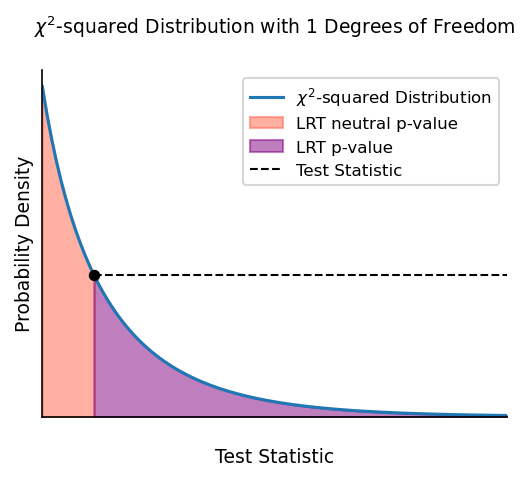

In [14]:
# Generate values for the chi-squared distribution
min_val = 1
max_val = 10
chi_stat = 2
dof = 1

fig, ax = plt.subplots(figsize=(4, 3))
x = np.linspace(min_val, max_val, 100)  # Adjust the range as needed
chi_squared_values = st.chi2.pdf(x, df=dof)

# Plot the chi-squared distribution
plt.plot(x, chi_squared_values, label=f'$\\chi^2$-squared Distribution')

# Highlight the area under the curve for the test statistic
plt.fill_between(x, chi_squared_values, where=(x <= chi_stat), color='tomato', alpha=0.5, label='LRT neutral p-value')
plt.fill_between(x, chi_squared_values, where=(x >= chi_stat), color='purple', alpha=0.5, label='LRT p-value')
plt.hlines(y=st.chi2.pdf(chi_stat, df=dof), xmin=chi_stat, xmax=max_val, linestyle='--', linewidth=1, color='black', label='Test Statistic')
plt.scatter(x=chi_stat, y=st.chi2.pdf(chi_stat, df=dof), color='black', s=20, zorder=4)

# Add labels and legend
plt.title(f'$\\chi^2$-squared Distribution with {dof} Degrees of Freedom\n', fontsize='9')
plt.xlabel('\nTest Statistic', fontsize='9')
plt.ylabel('Probability Density', fontsize='9')
plt.legend(fontsize='8')

# Show plot
# plt.grid(True)
sns.despine()
plt.xlim(min_val, max_val)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.ylim(0, )
plt.savefig("../supplement/Figures/S3C_LRT.png", dpi=300, bbox_inches='tight')

# Ungraded Variants

In [137]:
ungraded_muts = results_final.query("Reason=='Not Graded'")

In [139]:
ungraded_muts['Drug'].value_counts()

Drug
Linezolid       403
Capreomycin     378
Amikacin        369
Kanamycin       357
Streptomycin    343
Rifampicin      244
Ethambutol       68
Levofloxacin     48
Moxifloxacin     46
Isoniazid        28
Ethionamide      11
Pyrazinamide     11
Bedaquiline      10
Clofazimine       7
Delamanid         3
Name: count, dtype: int64

In [140]:
ungraded_muts['SOLO INITIAL CONFIDENCE GRADING'].value_counts()

SOLO INITIAL CONFIDENCE GRADING
3) Uncertain significance    2272
5) Not assoc w R               54
Name: count, dtype: int64